In [ ]:
<a href="https://colab.research.google.com/github/tvml/ml2324/blob/master/codici/backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rete neurale per riconoscere caratteri. Backpropagation implementata.

In [1]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import numpy as np
from scipy import io
import scipy.misc as mi
import scipy.special as sp

In [3]:
import urllib.request

filepath = "../dataset/"
url = "https://tvml.github.io/ml2324/dataset/"

def get_file(filename):
    IS_COLAB = ('google.colab' in str(get_ipython()))
    if IS_COLAB:
        urllib.request.urlretrieve (url+filename, filename)
        return filename
    else:
        return filepath+filename

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])

Function to render the raster image of a single digit, together with the corresponding value

In [5]:
def plotData(X, Y, c):
    m, n = X.shape
    image = np.array(X[c,:])
    plt.figure(figsize = (2,2))
    plt.imshow((image.reshape(20, 20)).T, cmap='Greys')
    plt.show()
    print("True number is " + str(Y[c].item()))

Function to display a grid of digit raster images 

In [6]:
# visualizza dati
def displayData(X, t, rows=10, cols=10, img_ind=None, size =16, class_value = False):
    if len(X)>rows*cols:
        img_ind = np.random.permutation(len(X))[0:rows * cols]
    else:
        img_ind = range(rows*cols)
    fig = plt.figure(figsize = (size,size))
    fig.patch.set_facecolor('white')
    ax = fig.gca()
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow([255-x for x in X[img_ind[i]].T], cmap='gray', interpolation='gaussian')
        if class_value:
            plt.title("{}".format(t[img_ind[i]]),fontsize = 20)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.axis('off')
    plt.subplots_adjust(top=1)
    plt.show()

Function to return statistics for test set x,t

In [7]:
def statistics(x,t, rows=10, cols=10):
    predclass = np.array([classify(x_)[1] for x_ in x])
    c = np.where(predclass==t.ravel(), 0, 1)
    d = np.nonzero(c)[0]
    print(predclass.reshape(rows, cols))
    print(str(np.sum(c))+' misclassifications out of '+str(len(x))+' items')
    for i in d:
        print('At ('+str(i/cols+1)+', '+str(i%cols+1)+'): '+str(t[i])+' classified as '+str(predclass[i]))
    print("Accuracy: %.2f%%" % (np.mean(predclass==t) * 100.0))

In [8]:
def sigmoid(theta, x):
    return sp.expit(np.dot(x, theta.T))

In [9]:
def softmax(theta, x):
    a = np.exp(np.dot(x, theta.T))
    s=np.sum(a,axis=1).reshape(-1,1)
    return a/s

In [10]:
# funzione di costo regolarizzata    
def cost(theta1, theta2, X, t):
    _,_,_,probs, y = classify(theta1,theta2,X)
    classes = np.arange(1, probs.shape[1] + 1)
    # rappresentazione 1-su-K delle classi predette
    P1 = (classes == y.reshape(-1,1)).astype(int)
    # rappresentazione complementare
    P0 = (classes != y.reshape(-1,1)).astype(int)
    # calcolo log-verosimiglianza
    lprobs1=-np.log(probs)
    lprobs0=-np.log(1.0-probs)
    term1 = np.trace(np.dot(lprobs1,P1.T))
    term2 = np.trace(np.dot(lprobs0,P0.T))
    c = term1+term2
    return c

In [11]:
# classificazione mediante softmax
def classify(theta1, theta2, X):
    m = len(X)
    x1  = np.column_stack((np.ones(m), X))
    z1 = sigmoid(theta1,x1)
    z1 = np.column_stack((np.ones(m), z1))
    z2 = softmax(theta2, z1)
    predictions = 1+np.argmax(z2, axis=1)
    return x1,z1,z2, predictions

In [12]:
# inizializza theta(w_out,w_in) con valori casuali
def init_theta(w_in, w_out):
    eps = np.sqrt(6)/np.sqrt(w_in+w_out)
    return np.random.uniform(-eps, eps, (w_in, w_out))    

In [13]:
def bp_step(theta1, theta2, X, t):
    theta1_grad = np.zeros_like(theta1)
    theta2_grad = np.zeros_like(theta2)
    m =len(X)
    classes = np.arange(1, theta2.shape[0] + 1)
    c = 0.0
    x1,z1,z2, predictions=classify(theta1,theta2,X)
    tk= (classes == t.reshape(-1,1)).astype(int)
    delta2 = z2-tk
    delta1 = z1*(1-z1)*np.dot(delta2, theta2)
    delta1 = delta1[:, 1:]
    for i in range(m):
        theta2_grad+=np.outer(delta2[i,:],z1[i,:])
        theta1_grad+=np.outer(delta1[i,:],x1[i,:])
        c += np.sum(-tk[i] * np.log(z2[i,:]) - (1.0 - tk[i]) * np.log(1.0 - z2[i,:]))
    theta1_grad /= m
    theta2_grad /= m
    c /= m
    return c, theta1_grad, theta2_grad

In [14]:
def backpropagation(hidden_layer_size, nclasses, X, t, alpha, iterations):
    theta1 = init_theta(hidden_layer_size, X.shape[1]+1)
    theta2 = init_theta(nclasses, hidden_layer_size+1)
    c_history = []
    acc_history = []
    for k in range(iterations):
        c, theta1_grad, theta2_grad = bp_step(theta1, theta2, X, t)
        theta1 -= alpha*theta1_grad
        theta2 -= alpha*theta2_grad
        c_history.append(c)
        _,_,probs, predictions = classify(theta1,theta2, X)
        acc_history.append(np.mean(np.where(predictions!=t.ravel(),0,1)))
    return theta1, theta2, c_history, acc_history

Read dataset from a file

In [15]:
data = io.loadmat(get_file('digits.mat'))

Extract feature matrix and target array. Set the label of class 10 to 0.

In [16]:
X, t = data['X'], data['y']
m, n = np.shape(X)
nclasses = 10
indx = np.random.permutation(5000)[0:100]
Xt = X[np.ix_(indx)].reshape([-1,20,20])
tt=t[np.ix_(indx)].reshape(1,-1)[0]

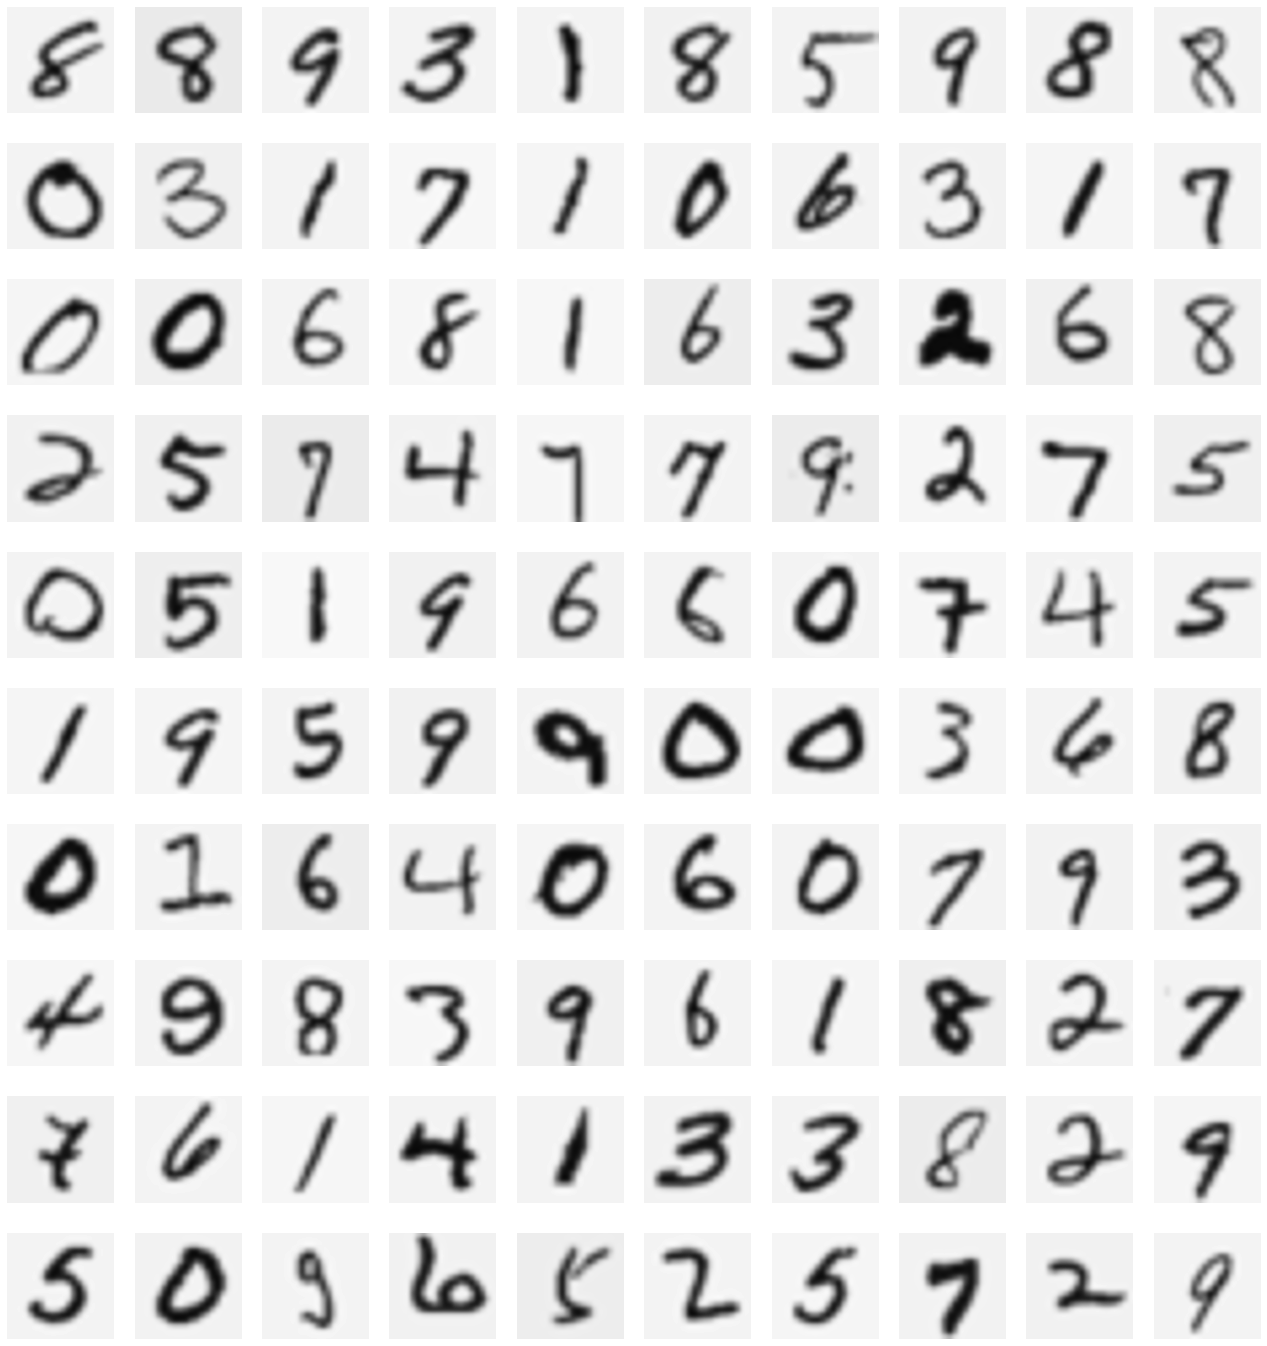

In [17]:
displayData(Xt, tt, size=20)

In [18]:
# dimensione rete neurale
input_layer_size = n
hidden_layer_size = 25
num_labels = nclasses

In [19]:
alpha = 1

In [20]:
theta1, theta2, c_history, acc_history = backpropagation(hidden_layer_size, nclasses, X, t, alpha, 100)

In [21]:
_,_,probs, predictions = classify(theta1, theta2, X)

acc = np.mean(np.where(predictions!=t.ravel(),0,1))
print(acc)

0.8914


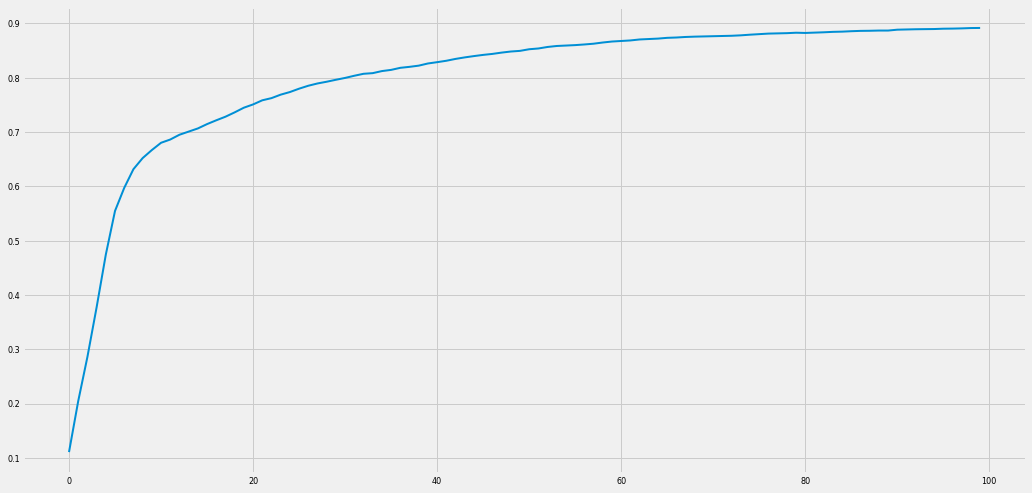

In [22]:
plt.plot(acc_history)